# TrendAnalysis object-oriented example


This juypter notebook is intended to demonstrate the RdTools analysis workflow as implemented with the `rdtools.TrendAnalysis` object-oriented API. For a consistent experience, we recommend installing the packages and versions documented in `docs/notebook_requirements.txt`. This can be achieved in your environment by running `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.)

The calculations consist of two phases:

1. Import and preliminary calculations: In this step data is important and augmented to enable analysis with RdTools. **No RdTools functions are used in this step. It will vary depending on the particulars of your dataset. Be sure to understand the inputs RdTools requires and make appropriate adjustments.**  
2. Analysis with RdTools: This notebook illustrates the use of the TrendAnalysis API to perform sensor and clearsky degradation rate calculations along with stochastic rate and recovery (SRR) soiling calculations.

This notebook works with data from the NREL PVDAQ `[4] NREL x-Si #1` system.  Note that because this system does not experience significant soiling, the dataset contains a synthesized soiling signal for use in the soiling section of the example.  This notebook automatically downloads and locally caches the dataset used in this example. The data can also be found on the DuraMAT Datahub (https://datahub.duramat.org/dataset/pvdaq-time-series-with-soiling-signal).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
%matplotlib inline

In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })
# Register time series plotting in pandas > 1.0
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Set the random seed for numpy to ensure consistent results
np.random.seed(0)

## Import and preliminary calculations


This section prepares the data necessary for an `rdtools` calculation.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

**The steps of this section may change depending on your data source or the system being considered. Note that nothing in this first section utilizes the `rdtools` library.** Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are available in [pvlib](https://github.com/pvlib/pvlib-python).

In [4]:
# Import the example data
file_url = ('https://datahub.duramat.org/dataset/a49bb656-7b36-'
            '437a-8089-1870a40c2a7d/resource/5059bc22-640d-4dd4'
            '-b7b1-1e71da15be24/download/pvdaq_system_4_2010-2016'
            '_subset_soilsignal.csv')
cache_file = 'PVDAQ_system_4_2010-2016_subset_soilsignal.pickle'

try:
    df = pd.read_pickle(cache_file)
except FileNotFoundError:
    df = pd.read_csv(file_url, index_col=0, parse_dates=True)
    df.to_pickle(cache_file)

In [5]:
df = df.rename(columns = {
    'ac_power':'power_ac',
    'wind_speed': 'wind_speed',
    'ambient_temp': 'Tamb',
    'poa_irradiance': 'poa',
})

# Specify the Metadata
meta = {"latitude": 39.7406,
        "longitude": -105.1774,
        "timezone": 'Etc/GMT+7',
        "gamma_pdc": -0.005,
        "azimuth": 180,
        "tilt": 40,
        "power_dc_rated": 1000.0,
        "temp_model_params":'open_rack_glass_polymer'}

df.index = df.index.tz_localize(meta['timezone'])

# Set the pvlib location
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])

# There is some missing data, but we can infer the frequency from
# the first several data points
freq = pd.infer_freq(df.index[:10])


This example dataset includes a synthetic soiling signal that can be applied onto the PV power data to illustrate the soiling loss and detection capabilities of RdTools.  AC Power is multiplied by soiling to create the synthetic 'power' channel

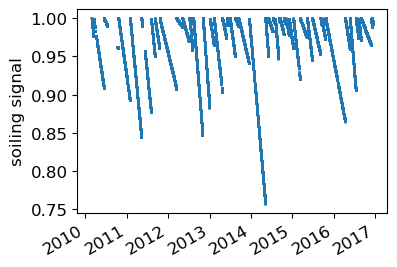

In [6]:
# Plot synthetic soiling signal attached to the dataset
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.soiling, 'o', alpha=0.01)
#ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('soiling signal');

df['power'] = df['power_ac'] * df['soiling']

## Use of the object oriented system analysis API

The first step is to create a `TrendAnalysis` instance containing data to be analyzed and information about the system. Here we illustrate a basic applicaiton, but the API is highly customizable and we encourage you to read the docstrings and check the source for full details.

In [7]:
ta = rdtools.TrendAnalysis(df['power'], df['poa'],
                           temperature_ambient=df['Tamb'],
                           gamma_pdc=meta['gamma_pdc'],
                           interp_freq=freq,
                           windspeed=df['wind_speed'],
                           power_dc_rated=meta['power_dc_rated'],
                           temperature_model=meta['temp_model_params'])

A second step is required to set up the clearsky model, which needs to be localized and have tilt/orientation information.

In [8]:
ta.set_clearsky(pvlib_location=loc, pv_tilt=meta['tilt'], pv_azimuth=meta['azimuth'], albedo=0.25)

Once the `TrendAnalysis` object is ready, the `sensor_analysis()` and `clearsky_analysis()` methods can be used to deploy the full chain of analysis steps. Results are stored in nested dict, `TrendAnalysis.results`.

Filters utilized in the analysis can be adjusted by changing the dict `TrendAnalysis.filter_params`.

Here we also illustrate how the aggregated data can be used to estimate soiling losses using the stochastic rate and recovery (SRR) method.<sup>1</sup> Since our example system doesn't experience much soiling, we apply an artificially generated soiling signal, just for the sake of example. If the dataset doesn't require special treatment, the 'srr_soiling' analysis type can just be added to the `sensor_analysis` function below. A warning is emitted here because the underlying RdTools soiling module is still experimental and subject to change.

<sup>1</sup>M. G. Deceglie, L. Micheli and M. Muller, "Quantifying Soiling Loss Directly From PV Yield," IEEE Journal of Photovoltaics, vol. 8, no. 2, pp. 547-551, March 2018. doi: 10.1109/JPHOTOV.2017.2784682

In [9]:
ta.sensor_analysis(analyses=['yoy_degradation','srr_soiling'])
ta.clearsky_analysis()

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\soiling.py:27: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(
c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\soiling.py:379: UserWarning: 20% or more of the daily data is assigned to invalid soiling intervals. This can be problematic with the "half_norm_clean" and "random_clean" cleaning assumptions. Consider more permissive validity criteria such as increasing "max_relative_slope_error" and/or "max_negative_step" and/or decreasing "min_interval_length". Alternatively, consider using method="perfect_clean". For more info see https://github.com/NREL/rdtools/issues/272
  warnings.warn('20% or more of the daily data is assigned to invalid soiling '


The results of the calculations are stored in a nested dict, `TrendAnalysis.results`

In [10]:
yoy_results = ta.results['sensor']['yoy_degradation']
srr_results = ta.results['sensor']['srr_soiling']

In [11]:
# Print the sensor-based analysis p50 degradation rate and confidence interval
print(np.round(yoy_results['p50_rd'], 3))
print(np.round(yoy_results['rd_confidence_interval'], 3))

-0.454
[-0.605 -0.253]


In [12]:
# Print the clear-sky-based analysis p50 degradation rate and confidence interval
cs_yoy_results = ta.results['clearsky']['yoy_degradation']
print(np.round(cs_yoy_results['p50_rd'], 3))
print(np.round(cs_yoy_results['rd_confidence_interval'], 3))

-0.509
[-0.761 -0.295]


In [13]:
# Print the p50 inoslation-weighted soiling ration and confidence interval
print(np.round(srr_results['p50_sratio'], 3))
print(np.round(srr_results['sratio_confidence_interval'], 3))

0.949
[0.944 0.954]


## Plotting
The `TrendAnalysis` class has built in methods for making useful plots

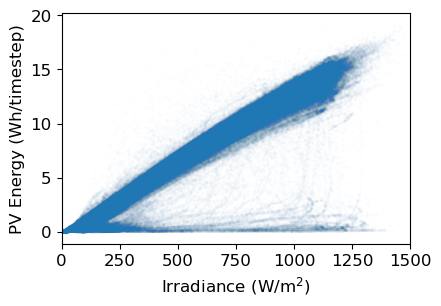

In [14]:
# check that PV energy is roughly proportional to irradiance
# Loops and other features in this plot can indicate things like
# time zone problems for irradiance transposition errors.
fig = ta.plot_pv_vs_irradiance('sensor');

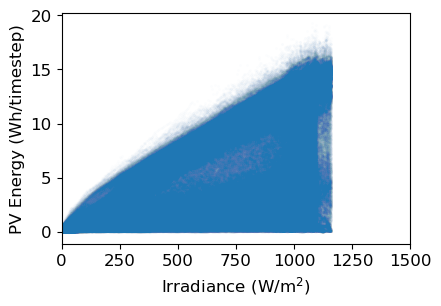

In [15]:
# Repeat the check for clear-sky irradiance
# For this plot, we expect more points below the main point
# cloud due to cloudy conditions.
fig = ta.plot_pv_vs_irradiance('clearsky');

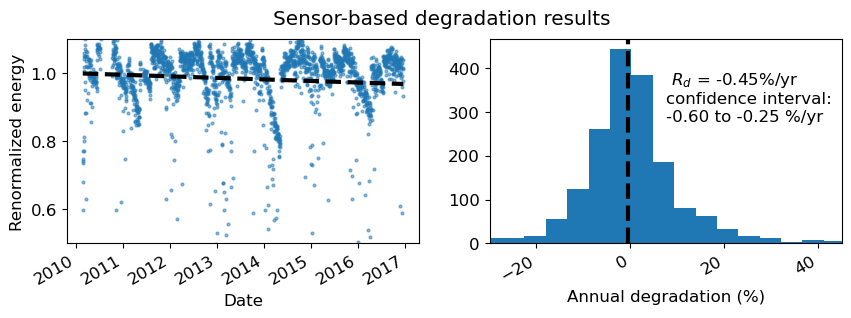

In [16]:
# Plot the sensor based degradation results
fig = ta.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                  scatter_ymin=0.5, scatter_ymax=1.1,
                                  hist_xmin=-30, hist_xmax=45);

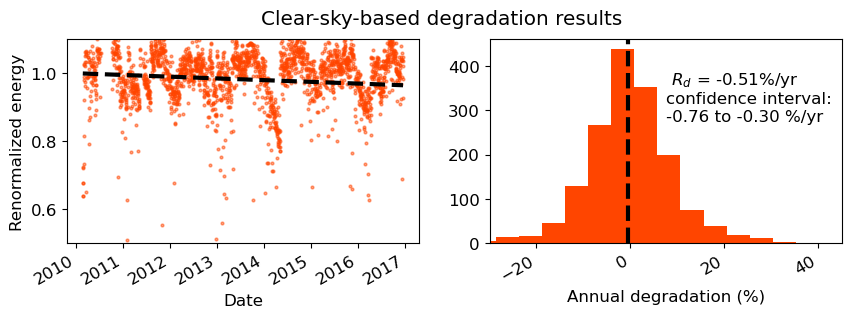

In [17]:
# Plot the clear-sky-based results
fig = ta.plot_degradation_summary('clearsky', summary_title='Clear-sky-based degradation results',
                                   scatter_ymin=0.5, scatter_ymax=1.1,
                                   hist_xmin=-30, hist_xmax=45, plot_color='orangered');

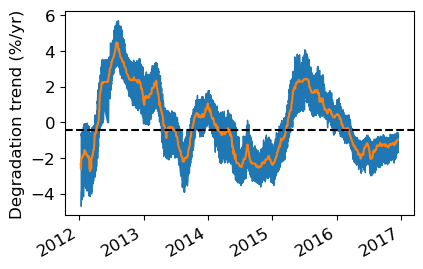

In [18]:
# Plot a time-dependent median (plus confidence interval) of sensor-based degradation results
fig = ta.plot_degradation_timeseries('sensor', rolling_days=365)

The TrendAnalysis class also has built-in methods for plots associated with soiling analysis

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:172: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(


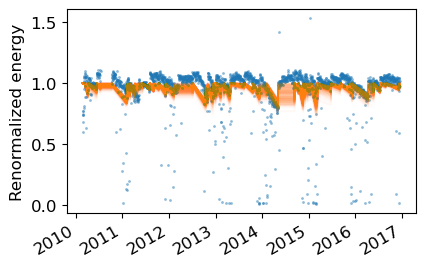

In [19]:
fig = ta.plot_soiling_monte_carlo('sensor', profile_alpha=0.01, profiles=500);

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:232: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(


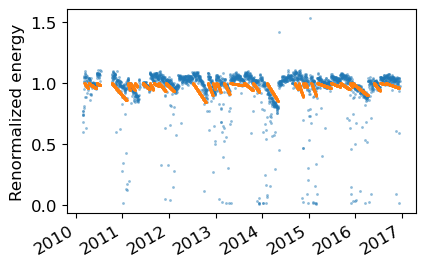

In [20]:
fig = ta.plot_soiling_interval('sensor');

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:272: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(


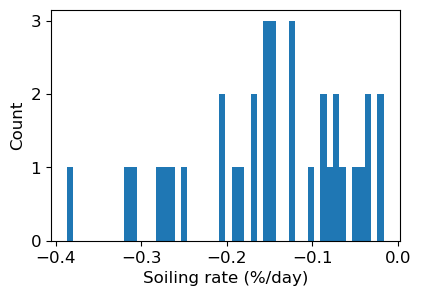

In [21]:
fig = ta.plot_soiling_rate_histogram('sensor', bins=50);

We can also view a table of the valid soiling intervals and associated metrics

In [22]:
interval_summary = ta.results['sensor']['srr_soiling']['calc_info']['soiling_interval_summary']
interval_summary[interval_summary['valid']].head()

,start,end,soiling_rate,soiling_rate_low,soiling_rate_high,inferred_start_loss,inferred_end_loss,length,valid
6,2010-03-11 00:00:00-07:00,2010-04-08 00:00:00-07:00,-0.001467,-0.004335,0.000000,1.037802,0.996718,28,True
8,2010-04-12 00:00:00-07:00,2010-06-13 00:00:00-07:00,-0.000701,-0.001058,-0.000336,1.012347,0.968893,62,True
10,2010-06-15 00:00:00-07:00,2010-07-13 00:00:00-07:00,-0.000639,-0.001763,0.000000,1.082671,1.064776,28,True
13,2010-10-11 00:00:00-07:00,2011-02-04 00:00:00-07:00,-0.001216,-0.001407,-0.001022,1.064267,0.923230,116,True
16,2011-02-13 00:00:00-07:00,2011-03-03 00:00:00-07:00,-0.003159,-0.005266,-0.001054,1.028467,0.971602,18,True


## Modifying and inspecting the filters
Filters can be adjusted from their default paramters by modifying the attribute `TrendAnalysis.filter_params`, which is a dict where the keys are names of functions in `rdtools.filtering`, and the values are a dict of the parameters for the associated filter. In the following example we modify the POA filter to have a low cutoff of 500 W/m^2 and use an alternate method in the clipping filter.

In [23]:
# Instantiate a new instance of TrendAnalysis
ta_new_filter = rdtools.TrendAnalysis(df['power'], df['poa'],
                                      temperature_ambient=df['Tamb'],
                                      gamma_pdc=meta['gamma_pdc'],
                                      interp_freq=freq,
                                      windspeed=df['wind_speed'],
                                      temperature_model=meta['temp_model_params'])

# Modify the poa and clipping filter parameters
ta_new_filter.filter_params['poa_filter'] = {'poa_global_low':500}
ta_new_filter.filter_params['clip_filter'] = {'model':'xgboost'}

# Run the YOY degradation analysis
ta_new_filter.sensor_analysis()

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\filtering.py:642: UserWarning: The XGBoost filter is an experimental clipping filter that is still under development. The API, results, and default behaviors may change in future releases (including MINOR and PATCH). Use at your own risk!
  warnings.warn("The XGBoost filter is an experimental clipping filter "


[13:58:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


In [24]:
# We can inspect the filter components with the attributes sensor_filter_components and clearsky_filter_components
ta_new_filter.sensor_filter_components.head()

,normalized_filter,poa_filter,tcell_filter,clip_filter
2010-02-25 14:16:00-07:00,False,False,True,True
2010-02-25 14:17:00-07:00,True,False,True,True
2010-02-25 14:18:00-07:00,True,False,True,True
2010-02-25 14:19:00-07:00,True,False,True,True
2010-02-25 14:20:00-07:00,True,False,True,True


In [25]:
# and we can inspect the final filter sensor_filter and clearsky_filter
ta_new_filter.sensor_filter.head()

2010-02-25 14:16:00-07:00    False
2010-02-25 14:17:00-07:00    False
2010-02-25 14:18:00-07:00    False
2010-02-25 14:19:00-07:00    False
2010-02-25 14:20:00-07:00    False
Freq: T, dtype: bool

In [26]:
# NBVAL_IGNORE_OUTPUT
# Visualize the filter
# these visualiztions can take up a lot of memory
# so just look at small subset of the data for this example
rdtools.tune_filter_plot(ta_new_filter.pv_energy['2013/01/01':'2013/01/21'],
                         ta_new_filter.sensor_filter['2013/01/01':'2013/01/21'])

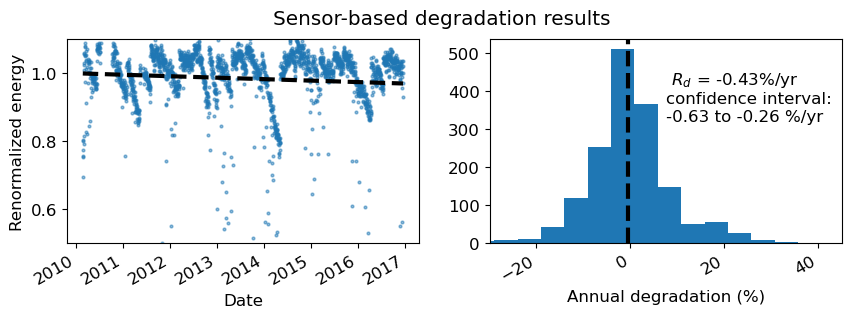

In [27]:
# Visualize the results
ta_new_filter.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                   scatter_ymin=0.5, scatter_ymax=1.1,
                                   hist_xmin=-30, hist_xmax=45);

### Using externally calculated filters
Arbitrary filters can also be used by setting the `ad_hoc_filter` key of the `TrendAnalysis.filter_params` atribute to a boolean pandas series that can be used as a filter. In this example we filter for "stuck" values, i.e. values that are repeated consecuatively, which can be associated with faulty measurments.

In [28]:
def filter_stuck_values(pandas_series):
    '''
    Returns a boolean pd.Series which filters out sequentially
    repeated values from pandas_series'
    '''
    diff = pandas_series.diff()
    diff_shift = diff.shift(-1)

    stuck_filter = ~((diff == 0) | (diff_shift == 0))

    return stuck_filter

In [29]:
# Instantiate a new instance of TrendAnalysis
ta_stuck_filter = rdtools.TrendAnalysis(df['power'], df['poa'],
                                        temperature_ambient=df['Tamb'],
                                        gamma_pdc=meta['gamma_pdc'],
                                        interp_freq=freq,
                                        windspeed=df['wind_speed'],
                                        temperature_model=meta['temp_model_params'])

In [30]:
stuck_filter =  (
                  filter_stuck_values(df['power']) &
                  filter_stuck_values(df['poa']) &
                  filter_stuck_values(df['Tamb']) &
                  filter_stuck_values(df['wind_speed'])
                 )

# reindex onto the same index that will be used for the other filters
stuck_filter = stuck_filter.reindex(ta_stuck_filter.poa_global.index, fill_value=True)

ta_stuck_filter.filter_params['ad_hoc_filter'] = stuck_filter

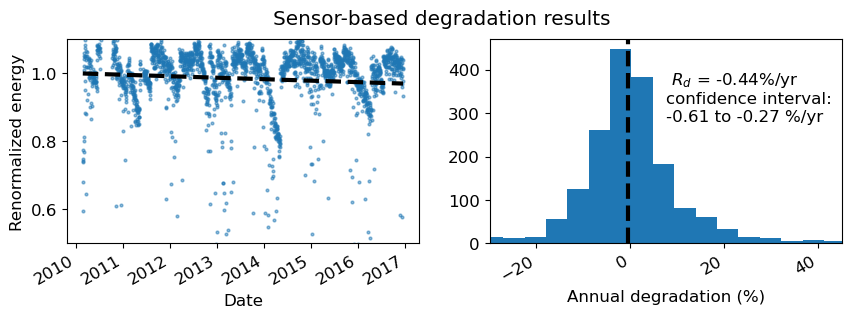

In [31]:
ta_stuck_filter.sensor_analysis()

# Visualize the results
ta_stuck_filter.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                         scatter_ymin=0.5, scatter_ymax=1.1,
                                         hist_xmin=-30, hist_xmax=45);